# ToDO 
Link to API
Remove compute!

# Two Point Spatial Correlation Calculation

In this notebook, we are demonstrating a simple case studies for calculating 2-point spatial correlations on experimental microstructure   and syntetic (generated) microstructures. First, we will demonstrate how to calculate spatial correlations for single 2 phase experimental image. Then , we will demonstrate the most efficient way to calculate 2-point spatial correlations on multiple microstructure  without using any for-loop. We will only use common python packages like `numpy`,`scikit-learn`, and `matplotlib` for this introductory notebook. For paralel (`dask`) and pipeline implementation please see the [Effective Siffness of a Composite Material example](./stress.ipynb) and [Effective Stiffness of Fiber Composite](./fiber.ipynb) 

Importing necessary packages to perform 2-point spatial correlations calculations

In [31]:
import warnings
import os

os.environ["OMP_NUM_THREADS"] = "1"
warnings.filterwarnings('ignore')

import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from pymks import (
    generate_multiphase,
    plot_microstructures,
    PrimitiveTransformer,
    TwoPointCorrelation,
    FlattenTransformer
)

In [32]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reading the Experimental Data


Let's read and visualize the experimental microstructure! This example is an segmented optical image.To obtain the statistical representation of the grain morphology ,grain interior and grain boundaries are the two different phases here[[1]](#References). 


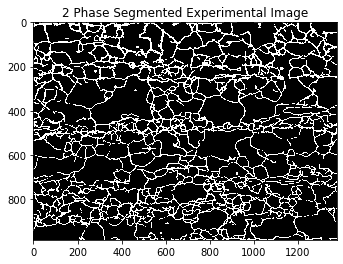

In [36]:
 from PIL import Image
im = Image.open('image.tiff')
plt.imshow(im,cmap='gray')
plt.title("2 Phase Segmented Experimental Image")
plt.show()

## Calculating the 2-point Stats

Pymks can handle both `numpy` and `dask` arrays. For simplicity, we will use `numpy` arrays for this notebook. The important note is `pymks` require certain data shape for proper 2-point spatial correlation calculation. For two dimensional microstructure ,`pymks` requires 4 dimensional array. First dimension is sample axis, second dimension is x axis , third dimension is y axis , and the forth dimension is the phase axis.In the phase axis , specific phase get's '1's and the rest of the image gets '0's. For this example, we have 2-phase segmented microstructre(986 x 1376) so we need to perform some array manipulations to obtain  1 x 986 x 1376 x 2 array. 

Let's convert the image to `numpy` array and add the sample axis by using `np.expand_dims`function. If you have multiple images you can simply stack them by using `numpy` data manupilation functions.

In [4]:
imarray = np.array(im)
imarray=np.expand_dims(imarray,axis=0)

In [39]:
imarray.shape

(1, 986, 1376)

Now let's add the phase axis. Since this is a binary microstructure , we can simply stack the inverted version of the image to original image. However, we are going to  demonstrate the `PrimitiveTransformer` that performes the same operation  and this transformer can be used for more complex cases as well. [ add reference]

In [40]:
nx_data=PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0).transform(imarray).compute()

In [41]:
nx_data.shape

(1, 986, 1376, 2)

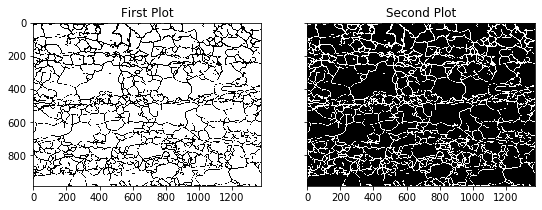

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
axs[0].imshow(nx_data[0,:,:,0],cmap='gray')
axs[0].title.set_text('First Plot')
axs[1].imshow(nx_data[0,:,:,1],cmap='gray')
axs[1].title.set_text('Second Plot')
plt.show()

In [8]:
TwoPt = TwoPointCorrelation(periodic_boundary=True, cutoff=25,correlations=[(0,0)])
AutoCorrelation = TwoPt.transform(nx_data).compute()

In [9]:
AutoCorrelation.shape

(1, 51, 51, 1)

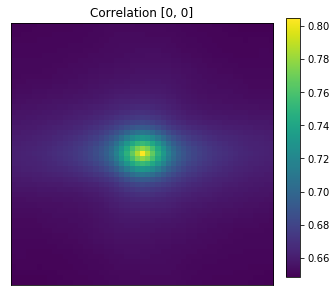

In [10]:
plot_microstructures(
    AutoCorrelation[0, :, :, 0],
    titles=['Correlation [0, 0]']
)

# Multiple Syntetic Microstructures

So you have your data. I am creating some random microstructures to show the procedure. `x_data` here will be your data (1x128x128). You don't need the code below.

In [11]:
da.random.seed(10)
np.random.seed(10)

x_data = da.concatenate([
    generate_multiphase(shape=(1, 128, 128), grain_size=(25, 25), volume_fraction=(0.5, 0.5)),
    
]).persist()

To visualize the data

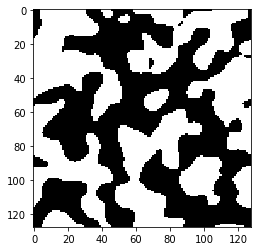

In [12]:
plt.imshow(x_data[0,:,:], cmap='gray')

I created the (1 x 128 x 128 x 1) 

In [13]:
x_data=x_data.reshape((1,128,128,1))
x_data.shape

(1, 128, 128, 1)

# You can start from here

This is how you can calculate the Two point stats. Here `(0,0)` means autocorrelation for the first state ( currentlty I have 1 x 128 x 128 x 1 ,and I have only one phase but your case you have 5 of them as your array is 1 x 128 x 128 x 5) Lets say you want to have 1 autocorrealtion of first phase and 2 crosscorrelations with next two phase ( - x - x- x 1 and - x - x- x 2) , then use ` correlations=[(0,0) , (0,1),(0,2)]`

In [14]:
TwoPt=TwoPointCorrelation(periodic_boundary=True, cutoff=25,correlations=[(0,0)])
AutoCorrelation=TwoPt.transform(x_data.compute())

If you want to visualize it, we have a function in pymks but you can just use matplotlib as well.

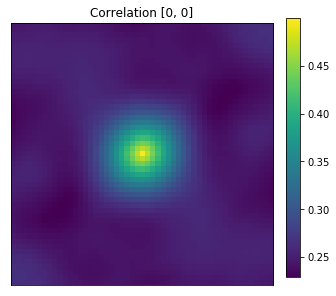

In [15]:
plot_microstructures(
    AutoCorrelation[0, :, :, 0],
    titles=['Correlation [0, 0]']
)

This was for single microstructure. Lets do it for multiple microstructures. I am again generating my own data you don't need the code below


In [16]:
da.random.seed(10)
np.random.seed(10)

nx_data = da.concatenate([
    generate_multiphase(shape=(20, 128, 128), grain_size=(25, 25), volume_fraction=(0.5, 0.5)),
    
]).persist()
nx_data=PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0).transform(nx_data).compute()



I created my microstructures and now I have (20 x 128 x 128 x 2). That means I have 20 microstructures ( all of them are 129 x 128 ) and I have 2 phases for each microstructure.

In [17]:
nx_data.shape

(20, 128, 128, 2)

I will use the same function but this time I will calculate `(0,0) and (0,1)`.

In [18]:
TwoPt=TwoPointCorrelation(periodic_boundary=True, cutoff=25,correlations=[(0,0),(0,1)])
AutoCorrelation=TwoPt.transform(nx_data).compute()

As you can see below I have correlations for all of my microstructures.- x - x - x 0 is (0,0) , - x - x - x 1 is (0,1)

In [19]:
AutoCorrelation.shape

(20, 51, 51, 2)

Then we flatten this data to use PCA

In [20]:
flatten=FlattenTransformer().transform(AutoCorrelation)

As you can see all the correlation information was flatten. Each row contains information for a single microstructure

In [21]:
flatten.shape

(20, 5202)

Then we do the PCA.

In [25]:
PC_scores=PCA(svd_solver='full', n_components=5).fit(flatten).transform(flatten)

Now we calculated the PC scores for each microstructure

In [26]:
PC_scores

array([[-0.06434185, -0.14664027,  0.22749412,  0.04047964,  0.0784144 ],
       [ 0.73447299, -0.23899686,  0.72259265, -0.40436187,  0.05611539],
       [-0.11845725,  0.33319871,  0.14709364, -0.10812686, -0.09647473],
       [-0.53464379, -0.10831666,  0.93845668,  0.1526426 ,  0.3080698 ],
       [-0.96450664, -0.50638643, -0.32484683,  0.69522489, -0.01541403],
       [-0.22341868, -0.6924235 , -0.25166085, -0.58555094, -0.17430349],
       [-0.21256212,  0.0832417 ,  0.17696143, -0.08414717,  0.05320936],
       [ 0.3696354 ,  0.02500941, -0.09125428, -0.29893808,  0.24534629],
       [-0.36691261,  0.65731715, -0.01749438, -0.04046878, -0.46703295],
       [-0.02541612,  0.33871871,  0.13449415, -0.05805418,  0.48224289],
       [ 0.01577694,  0.40286758, -0.6549982 ,  0.02420367,  0.46493001],
       [ 0.50081393, -0.1184354 , -0.05325768,  0.46147215, -0.22634153],
       [-0.28806578, -0.59842922, -0.16191097,  0.26947099,  0.17907329],
       [ 0.01932358,  0.14838255, -0.3

Finally lets visualize 

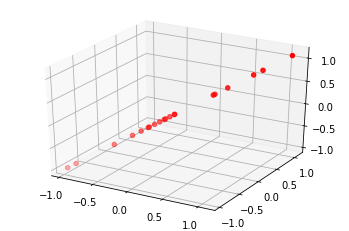

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(PC_scores[:,0], PC_scores[:,0], PC_scores[:,0], c='r', marker='o')

In [16]:
PC_scores[:,:3].shape

(20, 3)

# References

[1]  Yucel, B., Yucel, S., Ray, A. et al. Mining the Correlations Between Optical Micrographs and Mechanical Properties of Cold-Rolled HSLA Steels Using Machine Learning Approaches. Integr Mater Manuf Innov 9, 240–256 (2020). https://doi.org/10.1007/s40192-020-00183-3